$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os

In [19]:
import gdown
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory

# `+` Seed Value

In [20]:
SEED = 907
BATCH_SIZE = 32

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [21]:
# gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

In [22]:
# %%capture
# !unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [27]:
# Training Dataset

train_df = image_dataset_from_directory("Lung_Data",
                                        image_size=(512, 512),
                                        batch_size=BATCH_SIZE,
                                        seed=SEED,
                                        validation_split=0.2,
                                        subset="training")


Found 432 files belonging to 2 classes.
Using 346 files for training.


In [28]:
# Validation Dataset
validation_df = image_dataset_from_directory("Lung_Data",
                                            image_size=(512, 512),
                                            batch_size=BATCH_SIZE,
                                            seed=SEED,
                                            validation_split=0.2,
                                            subset="validation")

Found 432 files belonging to 2 classes.
Using 86 files for validation.


In [49]:
grey_train_ds = image_dataset_from_directory('Lung_Data/grey',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="training")


grey_val_ds = image_dataset_from_directory('Lung_Data/grey',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="validation")

Found 216 files.
Using 184 files for training.
Found 216 files.
Using 32 files for validation.


In [50]:
mask_train_ds = image_dataset_from_directory('Lung_Data/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="training")

mask_val_ds = image_dataset_from_directory('Lung_Data/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="validation")

Found 216 files.
Using 184 files for training.


Found 216 files.
Using 32 files for validation.


### Preview the Images

In [68]:
plt.figure(figsize=(10, 20), dpi=400)
for grey_batch, mask_batch in zip(grey_train_ds.take(4), mask_train_ds.take(4)):
    for i in range(len(grey_batch)):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(grey_batch[i].numpy().squeeze(), cmap='gray')  # Squeeze to remove single channel
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(mask_batch[i].numpy().squeeze(), cmap='gray')  # Squeeze to remove single channel
        plt.axis('off')
plt.tight_layout()
plt.show()


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} `channels` must be 0, 3 or 4 for BMP, but got 1
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

<Figure size 4000x8000 with 0 Axes>

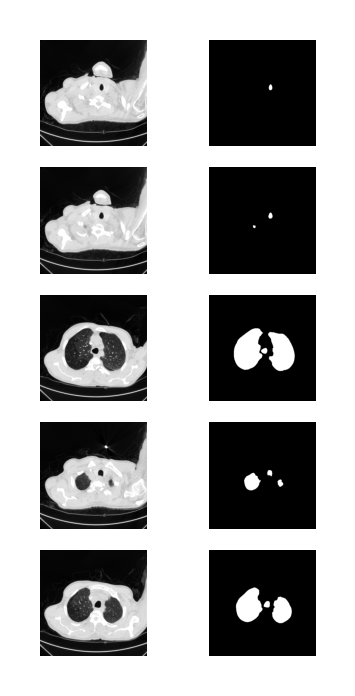

In [ ]:
# Preview Images


## `+` Set Global Parameters

In [59]:
# Hyperparameters
BATCH_SIZE  = 32
EPOCHS      = 50

## `i` Model Design

In [60]:
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

In [61]:
def augment_data(images, layers):
    for layer in layers:
        images = layer(images)
    return images

In [62]:
layers = [RandomFlip(), RandomRotation(0.2)]
augmented_train_ds = train_ds.map(lambda x, y: (augment_data(x, layers), y))

NameError: name 'train_ds' is not defined

In [ ]:
# Model Design 

model = keras.Sequential([

    keras.layers.InputLayer(input_shape=(512, 512, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),
    


## `ii` Model Compilation & Training

Epoch 1/50
23/23 [==============================] - 29s 1s/step - loss: 0.5495 - accuracy: 0.8799 - val_loss: 0.3917 - val_accuracy: 0.8872
Epoch 2/50
23/23 [==============================] - 23s 1s/step - loss: 0.4101 - accuracy: 0.8768 - val_loss: 0.3938 - val_accuracy: 0.8793
Epoch 3/50
23/23 [==============================] - 21s 938ms/step - loss: 0.3792 - accuracy: 0.8730 - val_loss: 0.4036 - val_accuracy: 0.8615
Epoch 4/50
23/23 [==============================] - 22s 963ms/step - loss: 0.2747 - accuracy: 0.8853 - val_loss: 0.2507 - val_accuracy: 0.8691
Epoch 5/50
23/23 [==============================] - 22s 966ms/step - loss: 0.2322 - accuracy: 0.8751 - val_loss: 0.2134 - val_accuracy: 0.8800
Epoch 6/50
23/23 [==============================] - 21s 928ms/step - loss: 0.1962 - accuracy: 0.8797 - val_loss: 0.1979 - val_accuracy: 0.9154
Epoch 7/50
23/23 [==============================] - 22s 946ms/step - loss: 0.1569 - accuracy: 0.9318 - val_loss: 0.2248 - val_accuracy: 0.9318
Epoch

## `iii` Model Evaluation

## `iv` Result Visualization

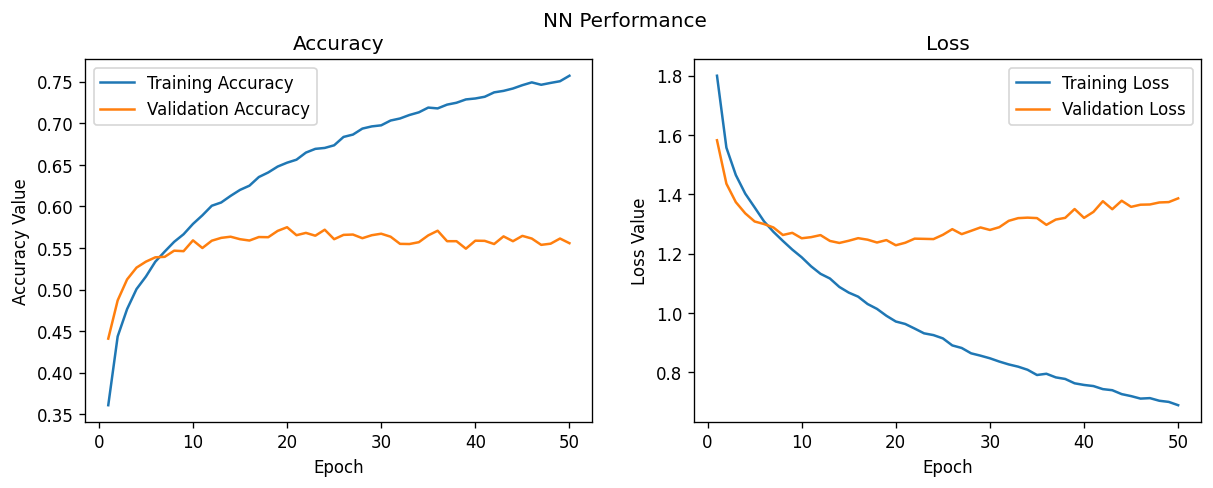

In [ ]:
# Plot the training and validation accuracy and loss


## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

1/1 [==============================] - 0s 28ms/step
1.04918666e-23 0.98422664


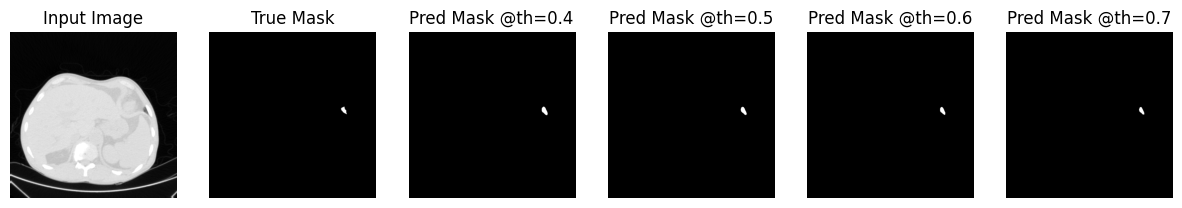

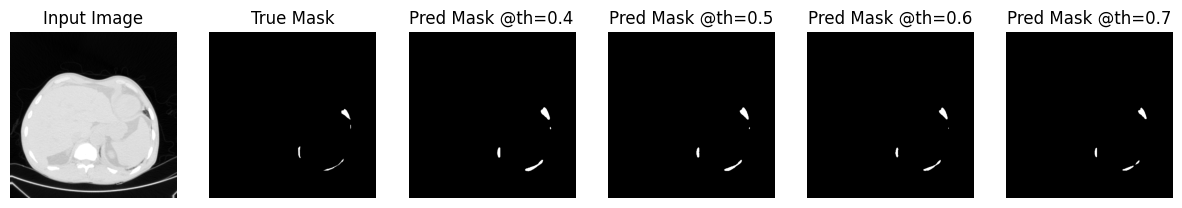

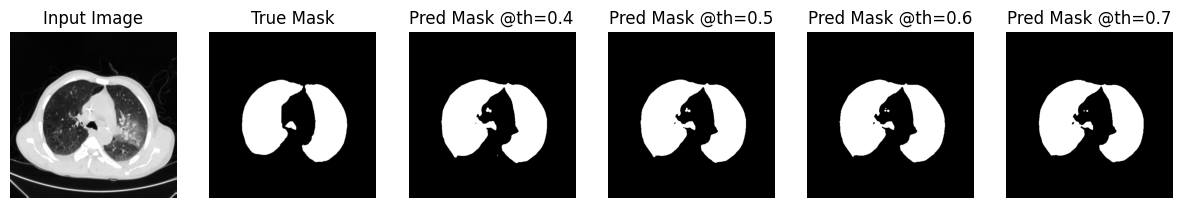

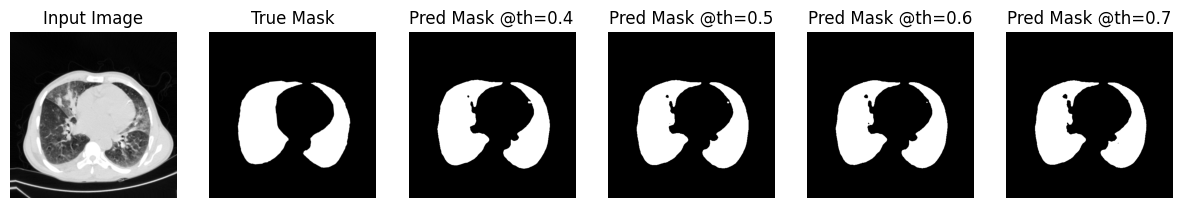

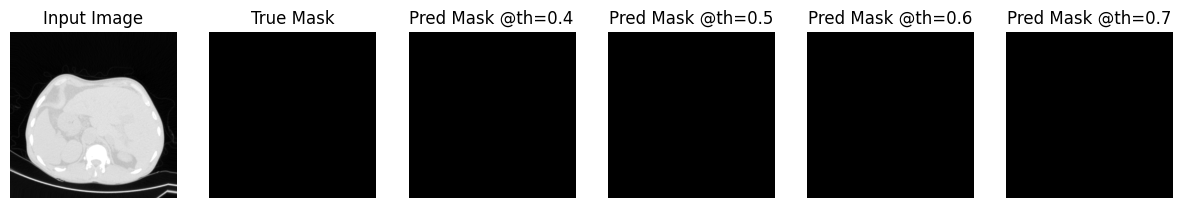

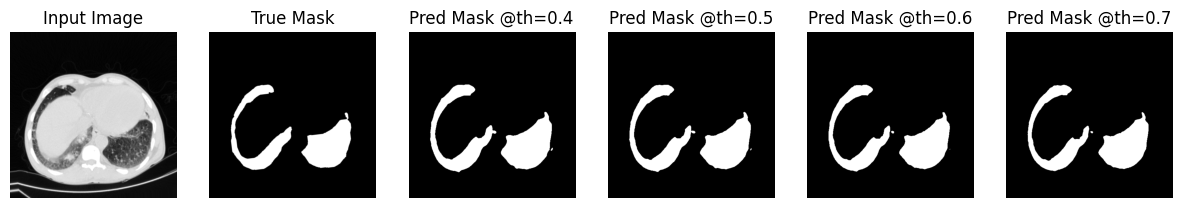

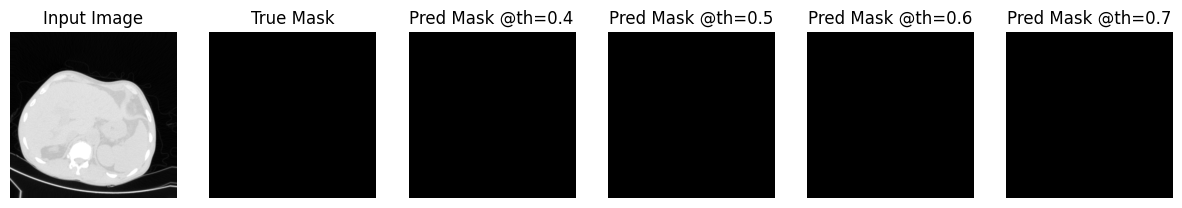

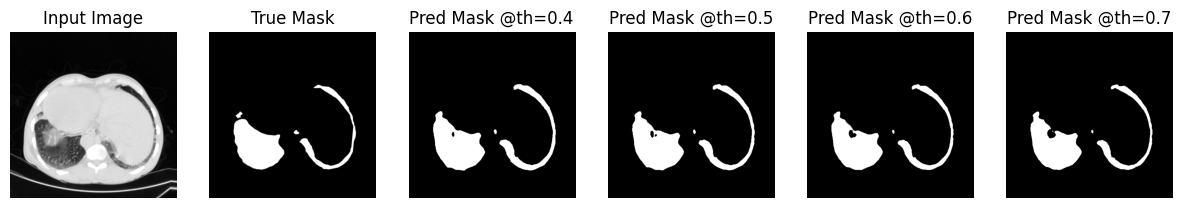

In [ ]:
# Plot the Input, True Mask, and Predicted Mask


**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [66]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   332k      0  0:40:24  0:40:24 --:--:--  463k36  0:01:25  1:37:11  126k 0:02:13  1:46:28 6923856  0:02:33  1:53:23 80946 1:49:45  163k44:31  217k 0:05:39  1:04:30  342k0:06:07  0:59:22  249k06:35  0:59:37  239k06  0:07:19  0:57:47  280k  0:07:25  0:57:38  191k  0:09:25  0:55:57 68187  0     0   227k      0  0:58:56  0:11:01  0:47:55  277k     0   228k      0  0:58:41  0:11:21  0:47:20  239k01  191k12:17  0:47:02  211k  0:48:10  122k 0   215k      0  1:02:15  0:13:43  0:48:32  119k13k      0  1:02:59  0:14:42  0:48:17  354k38  0:16:20  0:43:18  426k29  234M    0     0   232k      0  0:57:42  0:17:12  0:40:30  392k0:55:32  0:18:15  0:37:17  379kk9  0:23:50  423k23:48  0:23:20  333k22  0:22:16  344k  0:25:15  0:20:31  568k 0:45:40  0:25:19  0:20:21  569k0:16:26  467k6  0:15:55  417k05  384k  514M    0

In [67]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [ ]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
# Training/Validation Dataset


### Preview the Images

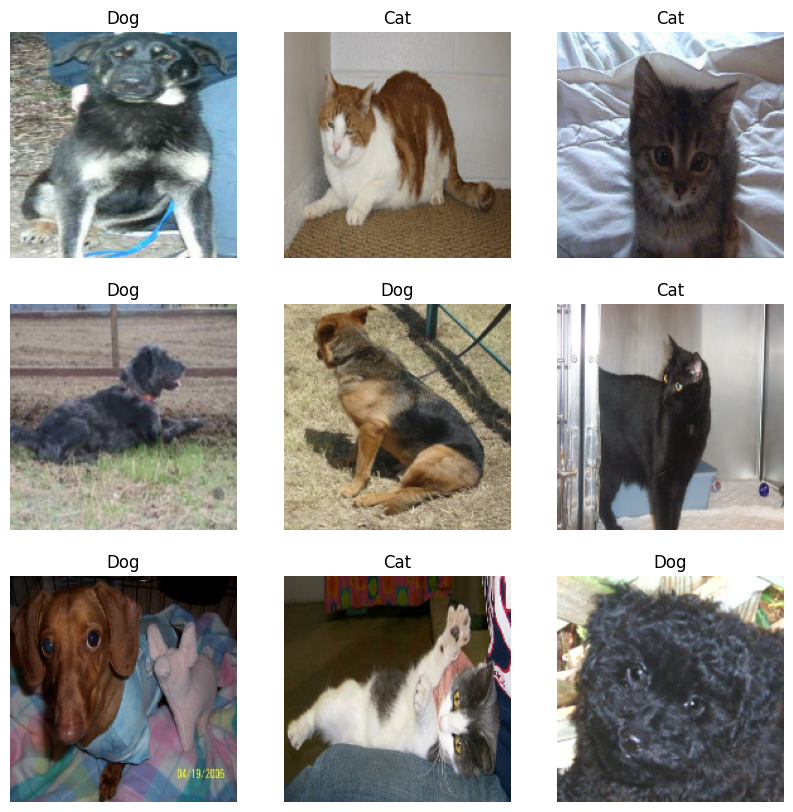

In [ ]:
# Preview Images


## `+` Set Global Parameters

In [ ]:
# Hyperparameters
BATCH_SIZE  =
EPOCHS      =

## `i` Model Design

## `ii` Model Compilation & Training

## `iii` Model Evaluation

## `iv` Result Visualization

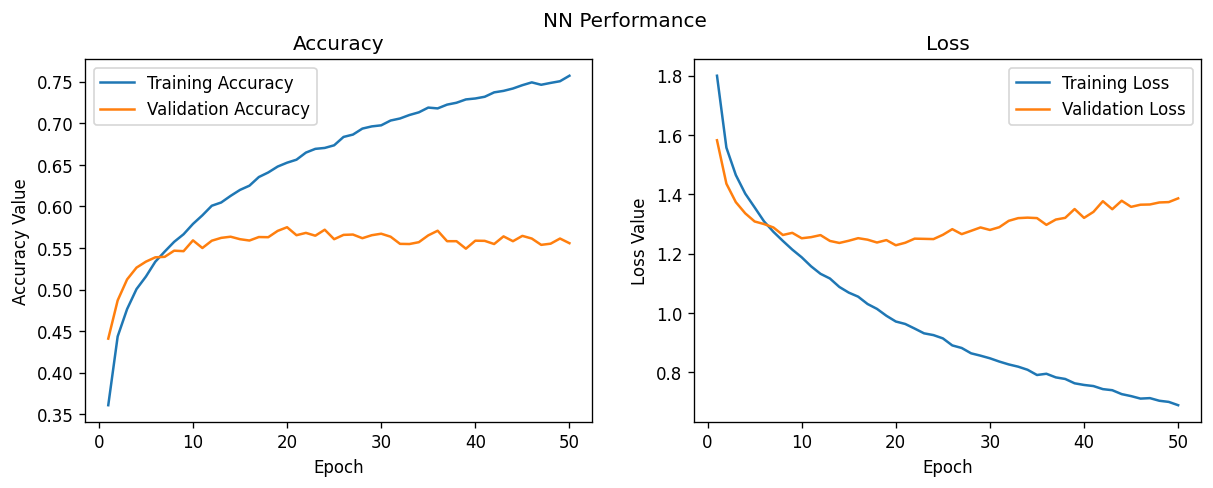

In [ ]:
# Plot the training and validation accuracy and loss


## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

In [ ]:
# Plot the Input, True Label, and Predicted Label


----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$